In [1]:
import numpy as np
import matplotlib.pyplot as plt

1 训练数据的生成

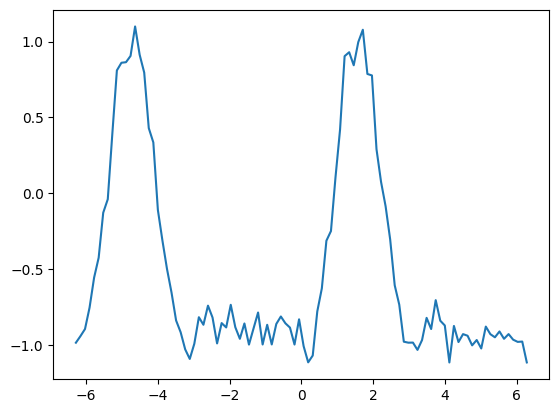

In [2]:
#  显示带噪声的曲线
sin_x = np.linspace(-2*np.pi, 2*np.pi, 100)
sin_y = np.sin(sin_x) ** 3 - np.cos(sin_x) ** 2 + 0.1 * np.random.randn(len(sin_x))# 使用随机数在sin函数中添加噪声

plt.plot(sin_x, sin_y)
plt.show()

In [3]:
len(sin_x)

100

2 数据的预处理

In [4]:
n_time = 10  # 时间序列的数量
n_in = 1  # 输入层的神经元数量
n_mid = 20  # 中间层的神经元数量
n_out = 1  # 输出层的神经元数量

n_sample = len(sin_x)-n_time  # 样本数量，n_time时间序列数据的数量
print(n_sample)

input_data = np.zeros((n_sample, n_time, n_in))  # 输入40个10行1列的数据
correct_data = np.zeros((n_sample, n_out))  # 正确答案

for i in range(0, n_sample):
    input_data[i] = sin_y[i:i+n_time].reshape(-1, 1)
    correct_data[i] = sin_y[i+n_time:i+n_time+1]  ## 正确答案位于输入之后的一位


90


In [5]:
np.shape(input_data) 

(90, 10, 1)

In [6]:
np.shape(correct_data)

(90, 1)

In [7]:
 input_data

array([[[-0.98564973],
        [-0.94228137],
        [-0.89541756],
        [-0.75430238],
        [-0.55637693],
        [-0.42527601],
        [-0.12850824],
        [-0.03975909],
        [ 0.3916521 ],
        [ 0.80978349]],

       [[-0.94228137],
        [-0.89541756],
        [-0.75430238],
        [-0.55637693],
        [-0.42527601],
        [-0.12850824],
        [-0.03975909],
        [ 0.3916521 ],
        [ 0.80978349],
        [ 0.8602367 ]],

       [[-0.89541756],
        [-0.75430238],
        [-0.55637693],
        [-0.42527601],
        [-0.12850824],
        [-0.03975909],
        [ 0.3916521 ],
        [ 0.80978349],
        [ 0.8602367 ],
        [ 0.86381409]],

       [[-0.75430238],
        [-0.55637693],
        [-0.42527601],
        [-0.12850824],
        [-0.03975909],
        [ 0.3916521 ],
        [ 0.80978349],
        [ 0.8602367 ],
        [ 0.86381409],
        [ 0.9052005 ]],

       [[-0.55637693],
        [-0.42527601],
        [-0.12850824],
   

In [8]:
 correct_data

array([[ 0.8602367 ],
       [ 0.86381409],
       [ 0.9052005 ],
       [ 1.09937722],
       [ 0.91269033],
       [ 0.79548234],
       [ 0.4292191 ],
       [ 0.33508053],
       [-0.11035014],
       [-0.31221174],
       [-0.49891286],
       [-0.65565099],
       [-0.83901708],
       [-0.91661669],
       [-1.02972   ],
       [-1.09261887],
       [-0.99250635],
       [-0.8175207 ],
       [-0.86728851],
       [-0.74129536],
       [-0.81962644],
       [-0.99039069],
       [-0.85625248],
       [-0.88496486],
       [-0.73567487],
       [-0.88336377],
       [-0.95988871],
       [-0.85880875],
       [-0.99810056],
       [-0.89204022],
       [-0.78647502],
       [-0.99745601],
       [-0.8674811 ],
       [-0.99712531],
       [-0.86204277],
       [-0.81278584],
       [-0.85768961],
       [-0.8858802 ],
       [-0.99773442],
       [-0.8312257 ],
       [-1.0083685 ],
       [-1.1150574 ],
       [-1.07015128],
       [-0.77917247],
       [-0.62710336],
       [-0

3 RNN网络类
其中包含了前向和反向传播算法，并且包含了梯度清零和优化

In [9]:
# -- RNN网络层  -- 
class SimpleRNNLayer:
    def __init__(self, n_upper, n):
        # 参数的初始值
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)  # Xavier的初始值
        self.v = np.random.randn(n, n) / np.sqrt(n)  # Xavier的初始值
        self.b = np.zeros(n)

    def forward(self, x, y_prev): # y_prev: 前一时刻的输出
        u = np.dot(x, self.w) + np.dot(y_prev, self.v) + self.b
        self.y = np.tanh(u)  # 输出
    
    def backward(self, x, y, y_prev, grad_y):
        delta = grad_y * (1 - y**2)

        # 各个梯度
        self.grad_w += np.dot(x.T, delta)
        self.grad_v += np.dot(y_prev.T, delta)
        self.grad_b += np.sum(delta, axis=0)

        self.grad_x = np.dot(delta, self.w.T)
        self.grad_y_prev = np.dot(delta, self.v.T)

    def reset_sum_grad(self):
        self.grad_w = np.zeros_like(self.w)
        self.grad_v = np.zeros_like(self.v)
        self.grad_b = np.zeros_like(self.b)

    def update(self, eta):
        self.w -= eta * self.grad_w
        self.v -= eta * self.grad_v
        self.b -= eta * self.grad_b

3 输出层 
  接收隐藏层传递过来的数据，并激活输出

In [10]:
# -- 全连接输出层 --
class OutputLayer:
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)  # # Xavier的初始值
        self.b = np.zeros(n)

    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = u  # 恒等函数

    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T) 

    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

4 训练函数train
  
  1 正向传播时输出的y传向后面的时刻。反向传播传递的是grad_y,传向前面的时刻。
  2 y_rnn存储了正向传播的数据原因grad_w依赖当前时刻y和前面时刻的y_prev.

In [11]:
# -- 训练 --
def train(x_mb, t_mb):
    # 正向传播 RNN网络层
    y_rnn = np.zeros((len(x_mb), n_time+1, n_mid))
    y_prev = y_rnn[:, 0, :]
    for i in range(n_time):
        x = x_mb[:, i, :]
        rnn_layer.forward(x, y_prev)
        y = rnn_layer.y
        y_rnn[:, i+1, :] = y   # 当前时刻的y
        y_prev = y             #存储成下一时刻y_prev

    # 正向传播 输出层
    output_layer.forward(y)

    # 反向传播 输出层
    output_layer.backward(t_mb)
    grad_y = output_layer.grad_x

    # 反向传播 RNN层
    rnn_layer.reset_sum_grad()
    for i in reversed(range(n_time)):
        x = x_mb[:, i, :]
        y = y_rnn[:, i+1, :]
        y_prev = y_rnn[:, i, :]
        rnn_layer.backward(x, y, y_prev, grad_y)
        grad_y = rnn_layer.grad_y_prev

    # 参数的更新
    rnn_layer.update(eta)
    output_layer.update(eta)

In [12]:
# -- 各项设置参数 --
n_time = 10  # 时间序列的数量
n_in = 1  # 输入层的神经元数量
n_mid = 20  # 中间层的神经元数量
n_out = 1  # 输出层的神经元数量

eta = 0.001  # 学习系数
epochs = 101
batch_size = 8
interval = 5  # 显示处理进度的间隔

In [13]:
# -- 生成训练数据集 --
# sin_x = np.linspace(-2*np.pi, 2*np.pi)  # 从−2π到2π
# sin_y = np.sin(sin_x)  + 0.1*np.random.randn(len(sin_x))  # 使用随机数向sin函数中添加噪声

# 2
# sin_x = np.linspace(-2*np.pi, 2*np.pi, 100)
# sin_x_squared = sin_x ** 2
#
# sin_y = np.sin(sin_x) ** 3 + sin_x_squared.astype(np.float32) - np.cos(sin_x) ** 2 + 0.1 * np.random.randn(len(sin_x))# 使用随机数在sin函数中添加噪声

# 3
sin_x = np.linspace(-2*np.pi, 2*np.pi, 100)
sin_y = np.sin(sin_x) ** 3 - np.cos(sin_x) ** 2 + 0.1 * np.random.randn(len(sin_x))# 使用随机数在sin函数中添加噪声

n_sample = len(sin_x)-n_time  # 样本数量

print(n_sample)

input_data = np.zeros((n_sample, n_time, n_in))  # 输入 40个10行1列的数据

correct_data = np.zeros((n_sample, n_out))  # 正确答案

for i in range(0, n_sample):
    input_data[i] = sin_y[i:i+n_time].reshape(-1, 1)
    correct_data[i] = sin_y[i+n_time:i+n_time+1]  ## 正确答案位于输入之后的一位

len(input_data)

#print(input_data)
#print(correct_data)
#len(correct_data)

90


90

In [14]:
# -- RNN网络层  -- 
class SimpleRNNLayer:
    def __init__(self, n_upper, n):
        # 参数的初始值
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)  # Xavier的初始值
        self.v = np.random.randn(n, n) / np.sqrt(n)  # Xavier的初始值
        self.b = np.zeros(n)

    def forward(self, x, y_prev): # y_prev: 前一时刻的输出
        u = np.dot(x, self.w) + np.dot(y_prev, self.v) + self.b
        self.y = np.tanh(u)  # 输出
    
    def backward(self, x, y, y_prev, grad_y):
        delta = grad_y * (1 - y**2)

        # 各个梯度
        self.grad_w += np.dot(x.T, delta)
        self.grad_v += np.dot(y_prev.T, delta)
        self.grad_b += np.sum(delta, axis=0)

        self.grad_x = np.dot(delta, self.w.T)
        self.grad_y_prev = np.dot(delta, self.v.T)

    def reset_sum_grad(self):
        self.grad_w = np.zeros_like(self.w)
        self.grad_v = np.zeros_like(self.v)
        self.grad_b = np.zeros_like(self.b)

    def update(self, eta):
        self.w -= eta * self.grad_w
        self.v -= eta * self.grad_v
        self.b -= eta * self.grad_b




In [15]:
# -- 全连接输出层 --
class OutputLayer:
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)  # # Xavier的初始值
        self.b = np.zeros(n)

    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = u  # 恒等函数

    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T) 

    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b



In [16]:
 #−− 各个网络层的初始化 −−
rnn_layer = SimpleRNNLayer(n_in, n_mid)
output_layer = OutputLayer(n_mid, n_out)



In [17]:
# -- 训练 --
def train(x_mb, t_mb):
    # 正向传播 RNN网络层
    y_rnn = np.zeros((len(x_mb), n_time+1, n_mid))
    y_prev = y_rnn[:, 0, :]
    for i in range(n_time):
        x = x_mb[:, i, :]
        rnn_layer.forward(x, y_prev)
        y = rnn_layer.y
        y_rnn[:, i+1, :] = y
        y_prev = y

    # 正向传播 输出层
    output_layer.forward(y)

    # 反向传播 输出层
    output_layer.backward(t_mb)
    grad_y = output_layer.grad_x

    # 反向传播 RNN层
    rnn_layer.reset_sum_grad()
    for i in reversed(range(n_time)):
        x = x_mb[:, i, :]
        y = y_rnn[:, i+1, :]
        y_prev = y_rnn[:, i, :]
        rnn_layer.backward(x, y, y_prev, grad_y)
        grad_y = rnn_layer.grad_y_prev

    # 参数的更新
    rnn_layer.update(eta)
    output_layer.update(eta)

In [18]:
# -- 预测 --
def predict(x_mb):
    # 正向传播 RNN层
    y_prev = np.zeros((len(x_mb), n_mid))
    for i in range(n_time):
        x = x_mb[:, i, :]
        rnn_layer.forward(x, y_prev)
        y = rnn_layer.y
        y_prev = y

    # 正向传播 输出层
    output_layer.forward(y)
    return output_layer.y



In [19]:
# -- 誤计算误差  --
def get_error(x, t):
    y = predict(x)
    return 1.0/2.0*np.sum(np.square(y - t))  # 误差平方和



Epoch:1/101 Error:21.372238378563253


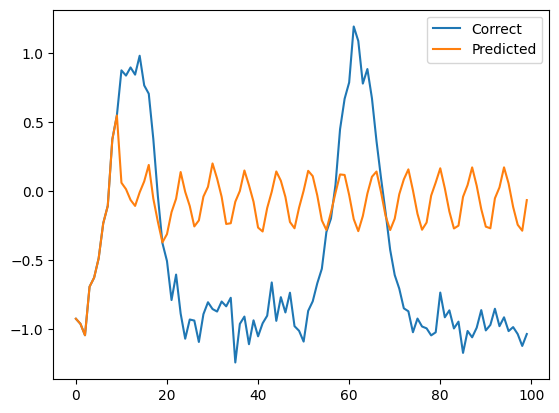

Epoch:6/101 Error:2.0649481553870452


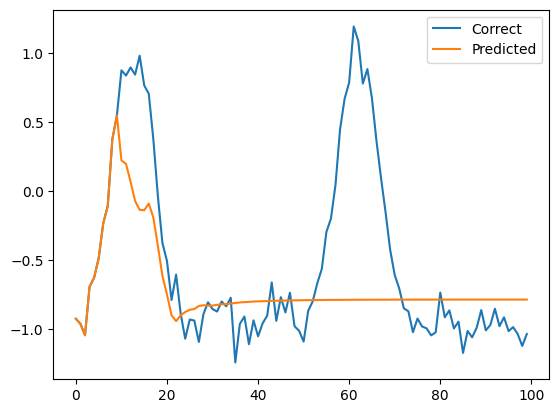

Epoch:11/101 Error:1.3022083353795537


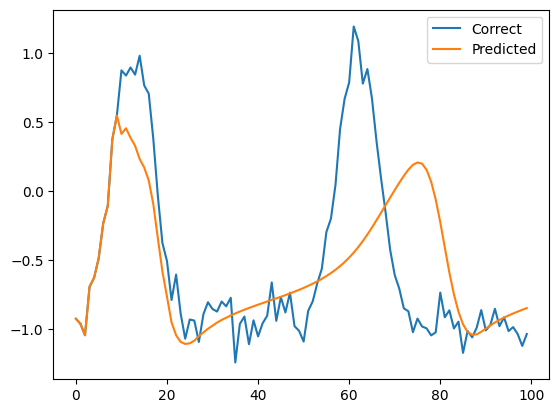

Epoch:16/101 Error:1.07334191774692


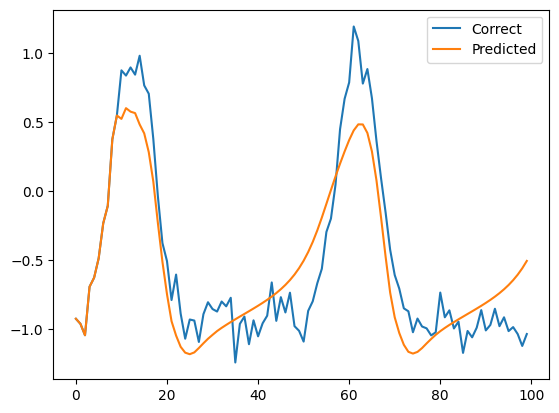

Epoch:21/101 Error:1.003814675350163


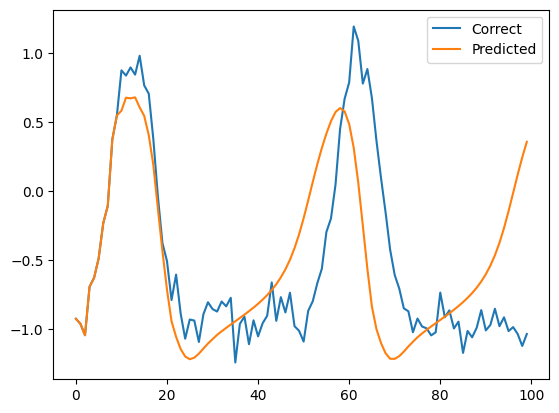

Epoch:26/101 Error:0.9734775114895549


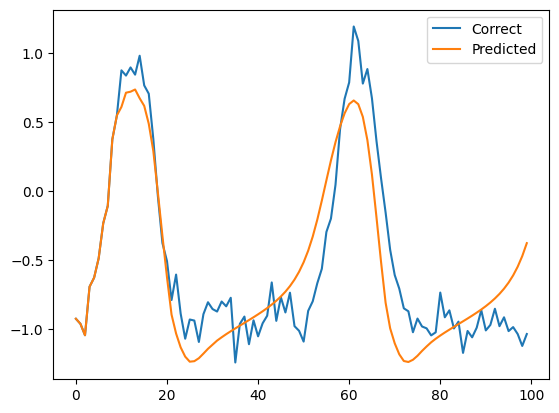

Epoch:31/101 Error:0.957898859502629


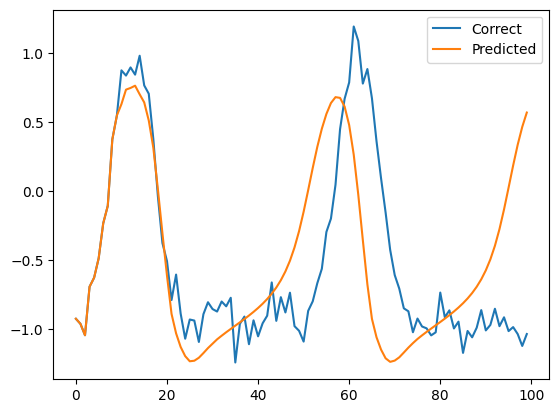

Epoch:36/101 Error:0.9389096895262291


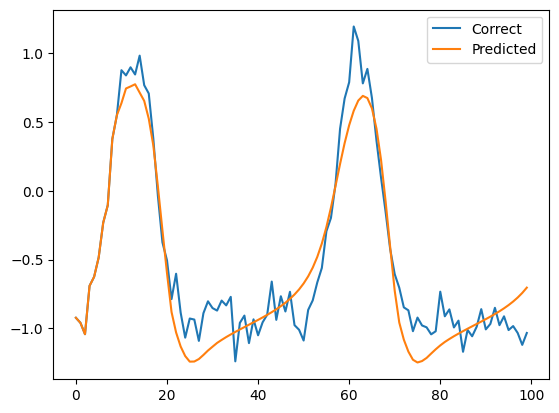

Epoch:41/101 Error:0.9258473962281613


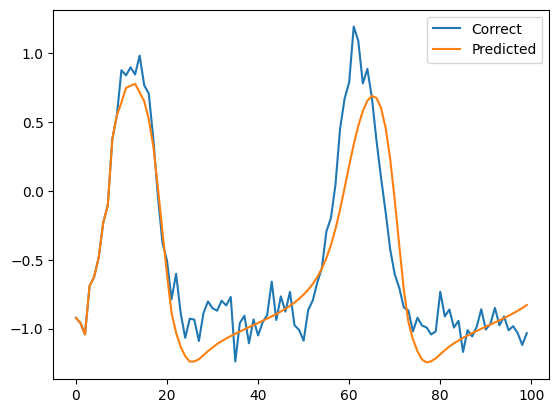

Epoch:46/101 Error:0.9147181465635156


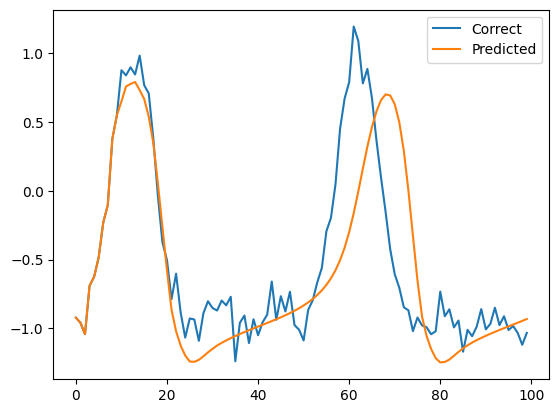

Epoch:51/101 Error:0.90338102388822


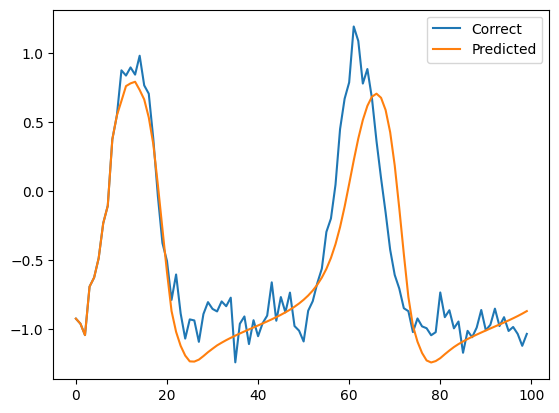

Epoch:56/101 Error:0.893558480737342


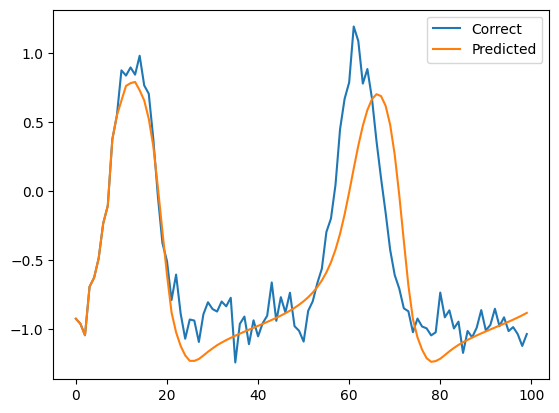

Epoch:61/101 Error:0.8862997192201556


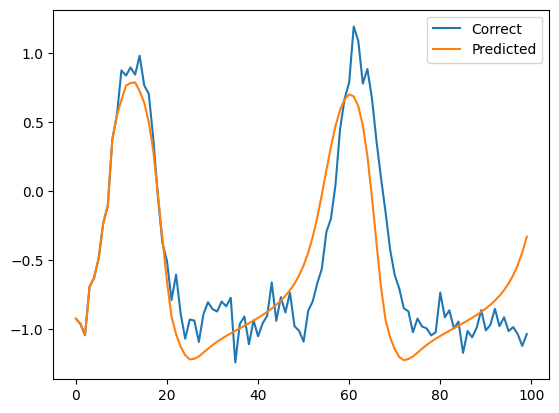

Epoch:66/101 Error:0.8763352467681083


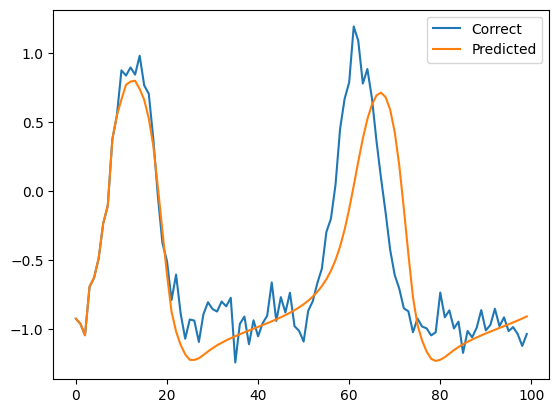

Epoch:71/101 Error:0.868803421391454


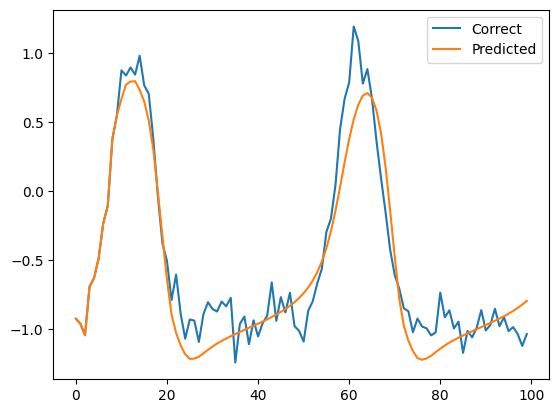

Epoch:76/101 Error:0.8615321804865966


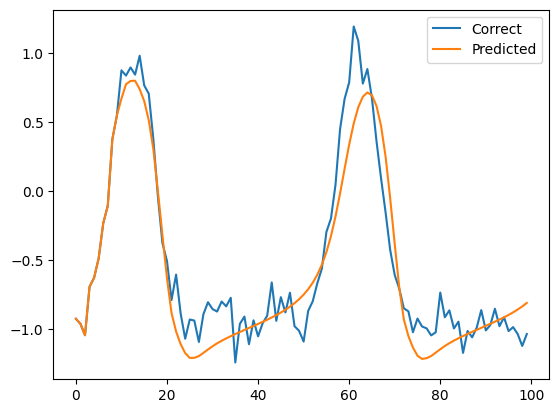

Epoch:81/101 Error:0.8554887606418157


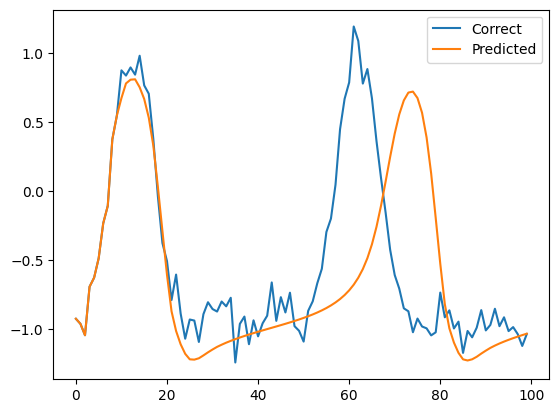

Epoch:86/101 Error:0.8495191736117488


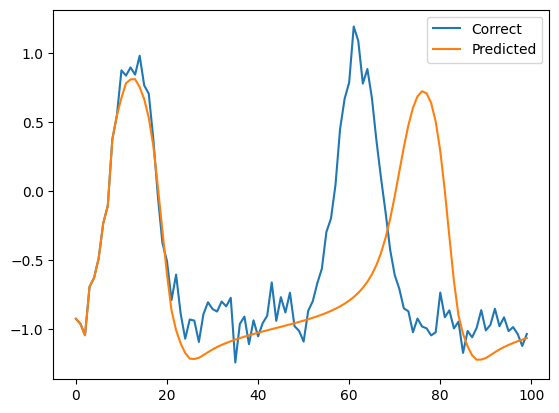

Epoch:91/101 Error:0.8437162221375749


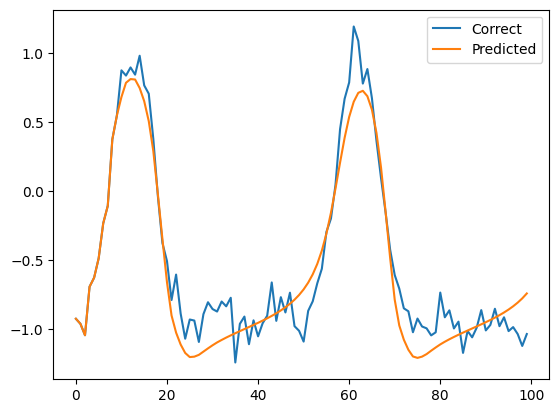

Epoch:96/101 Error:0.837665047203899


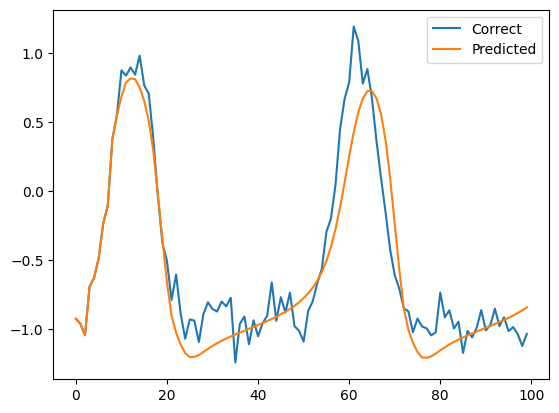

Epoch:101/101 Error:0.8319103610254983


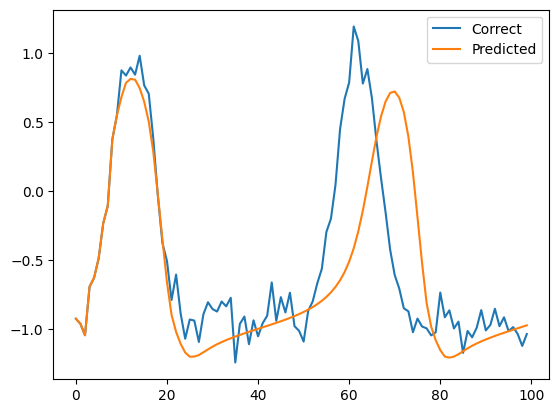

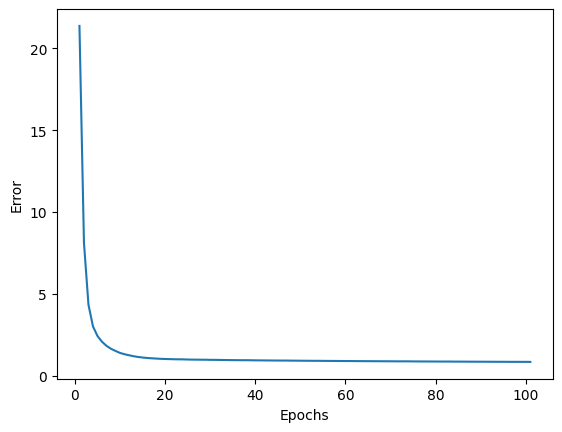

In [20]:
error_record = []
n_batch = len(input_data) // batch_size  # 每个epoch的批次数量

for i in range(epochs):
        
    # -- 学习 -- 
    index_random = np.arange(len(input_data))
    np.random.shuffle(index_random)  # 将索引打乱
    for j in range(n_batch):
        
        # 取出小批次数据进行训练
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x_mb = input_data[mb_index, :]
        t_mb = correct_data[mb_index, :]
        train(x_mb, t_mb)

    # -- 计算误差 --
    error = get_error(input_data, correct_data)
    error_record.append(error)

    # -- 显示处理进度 -- 
    if i%interval == 0:
        print("Epoch:"+str(i+1)+"/"+str(epochs), "Error:"+str(error))

        predicted = input_data[0].reshape(-1).tolist() # 起始的输入
        for i in range(n_sample):
            x = np.array(predicted[-n_time:]).reshape(1, n_time, 1)
            y = predict(x)
            predicted.append(float(y[0, 0]))  # 将输出添加到predicted中

        plt.plot(range(len(sin_y)), sin_y.tolist(), label="Correct")
        plt.plot(range(len(predicted)), predicted, label="Predicted")
        plt.legend()
        plt.show()

plt.plot(range(1, len(error_record)+1), error_record)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

In [21]:
arr3 = np.zeros((3, 6))

In [22]:
print(arr3)

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


In [23]:
arr3.reshape(-1,1)

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [24]:
index_random = np.arange(len(input_data))
print(index_random)
np.random.shuffle(index_random)  # 将索引打乱
print(index_random)

for j in range(1):
        
        # 取出小批次数据进行训练
    mb_index = index_random[j*batch_size : (j+1)*batch_size]
    x_mb = input_data[mb_index, :]
    print(x_mb)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]
[58  3 10 47 61 63  0 78 19 11 36 53 39  7 17 26 37 18 79 87 16 73  2 43
 28 67 15 31 25 55  4 83  8 49 70 60 50 32 45 64 76  6 74 56 44 46 29 38
 52 54 75 41 59 21 84 69 82 14 65 89 23 20 34 71 85 48 33 80 24 66 68 88
  5 30 77  1 35 12 40 22 62 27  9 13 51 81 86 57 72 42]
[[[ 0.45107727]
  [ 0.67133559]
  [ 0.78994679]
  [ 1.19516658]
  [ 1.09029214]
  [ 0.78132931]
  [ 0.88677688]
  [ 0.67477173]
  [ 0.36461044]
  [ 0.09526309]]

 [[-0.69075728]
  [-0.62523226]
  [-0.48465013]
  [-0.2313341 ]
  [-0.10432308]
  [ 0.37696622]
  [ 0.55037065]
  [ 0.87723458]
  [ 0.83943738]
  [ 0.89840585]]

 [[ 0.87723458]
  [ 0.83943738]
  [ 0.89840585]
  [ 0.84616529]
  [ 0.98323772]
  [ 0.76809708]
  [ 0.70785332]
  [ 0.37921661